input polygon: POLYGON ((-488539.5074633037 7541075.568426476, -488545.4817711225 7541100.35402546, -488543.35571942595 7541121.307109252, -488551.60245740676 7541148.345626224, -488544.972736628 7541168.206929285, -488548.18138848856 7541214.871617777, -488537.86558766983 7541277.354161341, -488545.72688159486 7541303.853158141, -488533.33577503986 7541326.6082438985, -488536.6334375104 7541344.698081128, -488526.9369757617 7541352.708528582, -488527.53418092337 7541380.726822117, -488524.07653252094 7541383.522613155, -488514.820361346 7541383.843075716, -488510.67901482095 7541387.735463638, -488501.0111485445 7541406.809893955, -488501.92265184864 7541423.018761466, -488497.57038355636 7541436.555266058, -488482.9829384308 7541452.247434409, -488484.79975379957 7541463.60842208, -488482.97278267314 7541477.94841642, -488477.2417573086 7541492.782420279, -488485.5541998214 7541516.606540787, -488473.79702680075 7541532.184806001, -488473.79081637174 7541547.354537406, -488466.683359

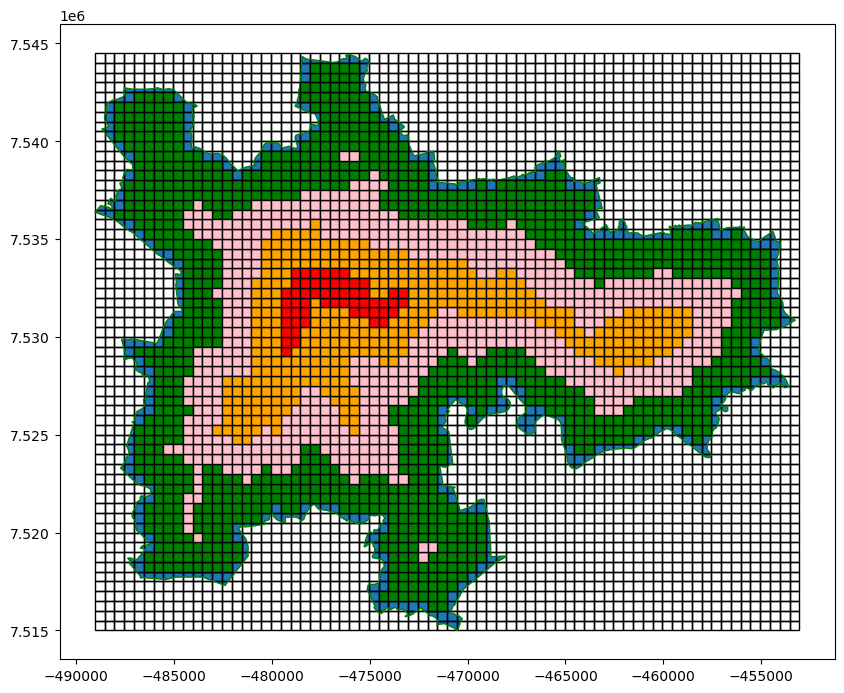

In [8]:
import geopandas as gpd
import pandas as pd
from pandas import Series
import shapely
from shapely import geometry
from shapely.ops import cascaded_union
from shapely import ops
from shapely import box, LineString, normalize, Point

from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
import numpy as np

def create_raster_grid(file_dir='scenarios/kildare/kildare.geojson',size_in_km=1, to_file=False, plot=False):
    # Create a fishnet 
    gdf = gpd.read_file(file_dir)

    # Reproject to projected coordinate system
    gdf = gdf.to_crs('EPSG:3857')
    poly = gdf['geometry'][0]
    poly_centroid = poly.centroid

    print("input polygon:", poly)

    # Get the extent of the shapefile
    total_bounds = gdf.total_bounds
 
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
 
    # Determine size of buffer
    poly_width = maxX-minX
    poly_height = maxY-minY

    if poly_width > poly_height:
        buffer_size = poly_width/22
    else:
        buffer_size = poly_height/22

    print("Buffer size = ", buffer_size)

    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = size_in_km * 1000
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet_dist = gpd.GeoDataFrame({'geometry': geom_array}).set_crs('EPSG:3857')
    fishnet_dist['dist_to_centroid'] = 0
    for i in range(0, len(fishnet_dist['geometry'])):
        geom_dist = poly_centroid.distance(fishnet_dist['geometry'][i].centroid) / 1000
        fishnet_dist.loc[i, 'dist_to_centroid'] = geom_dist


    fishnet = gpd.GeoSeries(geom_array).set_crs('EPSG:3857')
    #fishnet.to_file("scenarios/kildare/kildare_fishnet.geojson")

    poly_contains = gdf['geometry'][0].contains(fishnet)
    poly_raster = fishnet[poly_contains==True]
    if to_file:
        poly_raster.to_file(f"scenarios/kildare/kildare_raster_{size_in_km}.geojson")
        fishnet_dist.to_file(f"scenarios/kildare/fishnet_distances.geojson")

    
    poly_buffer1 =  poly.buffer(-buffer_size, join_style=2)
    buffer1 = poly_buffer1.contains(poly_raster)

    poly_buffer2 =  poly_buffer1.buffer(-buffer_size, join_style=2)
    buffer2 = poly_buffer2.contains(poly_raster)

    poly_buffer3 =  poly_buffer2.buffer(-buffer_size, join_style=2)
    buffer3 = poly_buffer3.contains(poly_raster)

    raster_A = poly_raster[(buffer1==False) & (buffer2==False) & (buffer3==False)]
    raster_B = poly_raster[(buffer1==True) & (buffer2==False) & (buffer3==False)]
    raster_C = poly_raster[(buffer2==True) & (buffer3==False)]
    raster_D = poly_raster[(buffer3==True)]
    

    gdf_buffers = gpd.GeoDataFrame({'geometry': [poly_buffer1, poly_buffer2, poly_buffer3, poly]})

    if plot:
        fig, ax = plt.subplots(figsize=(10,15))

        gdf.plot(ax=ax)
        fishnet_dist.plot(ax=ax, facecolor='none', edgecolor='black')
        gdf_buffers.plot(ax=ax, facecolor='none', edgecolor='green')
        raster_A.plot(ax=ax, facecolor='green', edgecolor='black')
        raster_B.plot(ax=ax, facecolor='pink', edgecolor='black')
        raster_C.plot(ax=ax, facecolor='orange', edgecolor='black')
        raster_D.plot(ax=ax, facecolor='red', edgecolor='black')

        plt.show()
        
    multi_A = shapely.geometry.MultiPolygon(raster_A.values.tolist())
    multi_B = shapely.geometry.MultiPolygon(raster_B.values.tolist())
    multi_C = shapely.geometry.MultiPolygon(raster_C.values.tolist())
    multi_D = shapely.geometry.MultiPolygon(raster_D.values.tolist())

    multi_list = [multi_A, multi_B, multi_C, multi_D]

    gdf_rasters = gpd.GeoDataFrame(pd.DataFrame(multi_list, columns=['geometry']), geometry='geometry')

    return gdf_rasters

_ = create_raster_grid('scenarios/glasgow/2579.geojson', size_in_km=0.5, plot=True)